## Time embedding

![image](TimeEmbedding.PNG)

In [1]:
from nn_layers import Embedding, Adam, SGD,TimeRNN, RNN

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class TimeEmbedding:
    def __init__(self,W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
            
    def forward(self, xs): # 출력할 거  ->  N : batch size , T : sequence length, D : input size
        N, T = xs.shape
        V, D = self.W.shape # V : vacab size, 사용x
        
        out = np.empty((N,T,D),dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:,t,:] = layer.forward(xs[:,t])
            # Embedding 계층을 사용하여 t번째 데이터를 사용해 forward호출
            # 출력된 각각의 2차원(N,D)배열을 3차원 배열(N,T,D)에 저장
            
            self.layers.append(layer)
        
        return out # N,T,D
        
    def backward(self,dout):
        N ,T ,D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:,t,:])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None
    
# NTD로 들어와 NTH로 나간다.(각 NT로 나가고 H개)

In [3]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self,x):
        N,T,D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T,-1) # 2차원 내적곱
        out = np.dot(rx,W) + b
        self.x =x
        return out.reshape(N,T,-1) # 3차원 출력
        
    def backward(self, dout):  # Affine계층과 같음
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape) # 3차원

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

    
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def softmax(self,x):
        if x.ndim == 2:
            x = x - x.max(axis=1, keepdims=True)
            x = np.exp(x)
            x /= x.sum(axis=1, keepdims=True)
        elif x.ndim == 1:
            x = x - np.max(x)
            x = np.exp(x) / np.sum(np.exp(x))

        return x        

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)  # label 이 -1이 아닌 값만 True 가  되는 2차원 배열을 생성

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)   # 2차원으로
        ts = ts.reshape(N * T)      # 1차원으로
        mask = mask.reshape(N * T)  # 1차원으로 
        ys = self.softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask                # ignore_label(-1)에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)        # T개의 loss를 합한다
        loss /= mask.sum()        # 평균

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys        # softmax의 출력 값과
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label(-1)에 해당하는 데이터는 기울기를 0으로 설정, mask를 2차원으로 변경하여 곱해줌

        dx = dx.reshape((N, T, V)) # 다시 3차원으로 변경

        return dx


In [4]:
import numpy as np
a = np.newaxis
print(a)      # np.newaxis ==> None

x1 = np.arange(25)
print(x1)
# x2 = x1[:,np.newaxis]
# print(x2)
# x3 = x1.reshape(-1,1)
# print(x3)


None
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [5]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H =  vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype('f')
        rnn_Wx = (rn(D,H)/np.sqrt(D)).astype('f') # Xavier(GLorot) 초기화
        rnn_Wh = (rn(H,H)/np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b,stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
            
    def reset_state(self):
        self.rnn_layer.reset_state()

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 200

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))
print(data_size) # 999
# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []


말뭉치 크기: 1000, 어휘 수: 418
999


In [13]:
SimpleRnnlm(1,2,3)

In [14]:
# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size            # 990//10 = 99
offsets = [i * jump for i in range(batch_size)]   # [0, 99, 198, 297, 396, 495, 594, 693, 792, 891]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]  # xs[(0+0)%999], xs[(0+99)%999]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
                # print('i:',i,'t:',t,'offset..:',(offset + time_idx) % data_size)
            time_idx += 1
            

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
       


| 에폭 1 | 퍼플렉서티 374.98
| 에폭 2 | 퍼플렉서티 254.24
| 에폭 3 | 퍼플렉서티 222.89
| 에폭 4 | 퍼플렉서티 214.34
| 에폭 5 | 퍼플렉서티 204.96
| 에폭 6 | 퍼플렉서티 201.75
| 에폭 7 | 퍼플렉서티 198.57
| 에폭 8 | 퍼플렉서티 196.48
| 에폭 9 | 퍼플렉서티 191.25
| 에폭 10 | 퍼플렉서티 193.00
| 에폭 11 | 퍼플렉서티 188.72
| 에폭 12 | 퍼플렉서티 191.50
| 에폭 13 | 퍼플렉서티 189.76
| 에폭 14 | 퍼플렉서티 189.96
| 에폭 15 | 퍼플렉서티 188.45
| 에폭 16 | 퍼플렉서티 185.35
| 에폭 17 | 퍼플렉서티 184.51
| 에폭 18 | 퍼플렉서티 182.16
| 에폭 19 | 퍼플렉서티 182.38
| 에폭 20 | 퍼플렉서티 184.96
| 에폭 21 | 퍼플렉서티 184.45
| 에폭 22 | 퍼플렉서티 179.00
| 에폭 23 | 퍼플렉서티 177.78
| 에폭 24 | 퍼플렉서티 177.20
| 에폭 25 | 퍼플렉서티 175.22
| 에폭 26 | 퍼플렉서티 174.48
| 에폭 27 | 퍼플렉서티 172.61
| 에폭 28 | 퍼플렉서티 167.72
| 에폭 29 | 퍼플렉서티 168.30
| 에폭 30 | 퍼플렉서티 162.62
| 에폭 31 | 퍼플렉서티 162.83
| 에폭 32 | 퍼플렉서티 159.49
| 에폭 33 | 퍼플렉서티 157.84
| 에폭 34 | 퍼플렉서티 155.95
| 에폭 35 | 퍼플렉서티 153.54
| 에폭 36 | 퍼플렉서티 148.87
| 에폭 37 | 퍼플렉서티 144.31
| 에폭 38 | 퍼플렉서티 141.97
| 에폭 39 | 퍼플렉서티 136.12
| 에폭 40 | 퍼플렉서티 131.69
| 에폭 41 | 퍼플렉서티 134.85
| 에폭 42 | 퍼플렉서티 127.24
| 에폭 43 | 퍼플렉서티 122.14
| 에폭 44 | 퍼플렉서티 118.

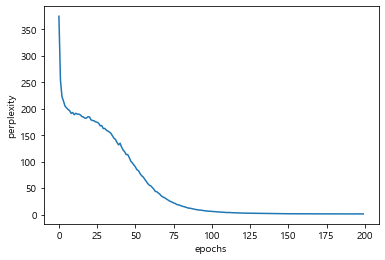

In [15]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

## LSTM(Long Short Term Memory)

https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr

Wh:
 [[ 1.78862847  0.43650985  0.09649747]
 [-1.8634927  -0.2773882  -0.35475898]
 [-0.08274148 -0.62700068 -0.04381817]]
[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


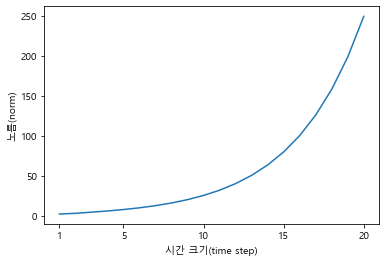

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)          # 기울기 폭발 (스칼라일 경우 Wh가 1보다 큰경 우)  --> NaN
# Wh = np.random.randn(H, H) * 0.5  # 기울기 소실 (스칼라일 경우 Wh가 1보다 작은 경우) --> 0
print('Wh:\n',Wh)


# Norm은 벡터의 길이 혹은 크기를 측정하는 방법(함수)이다
# L1 norm : 벡터의 각 요소의 절대값을 모두 합한 값
# L2 norm : 각 요소의 제곱을 모두 합하여 제곱근을 취한 값
# http://taewan.kim/post/norm/
norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()


### 기울기 폭발 대책 : 기울기 클리핑(gradient cliping) 함수 구현
https://wikidocs.net/61375

#### 기울기 소실 방지 : Gated RNN 인 LSTM(Long Short Term Memory)이나  GRU(Gated Recurrent Units ) 사용
#### LSTM  : RNN에 기억 셀 𝐜<sub>𝐭</sub> 과 , f , g, i, o 게이트 추가

In [16]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
print('dW1:\n',dW1)
print('dW2:\n',dW2)
grads = [dW1, dW2]
max_norm = 5.0  # threshold, 한계값

## nn_layers.py 에 추가한다
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:  # L2 norm 구하기 , 제곱의 합의 제곱근
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1: # total_norm 이 한계값(max_norm) 보다 클경우
        for grad in grads:
            grad *= rate

print('(dW1) before:', dW1.flatten())
clip_grads(grads, max_norm)
print('(dw1) after:', dW1.flatten())  # 값이 약간 줄어듦


dW1:
 [[9.47336627 1.28659998 4.89136288]
 [7.47823221 0.71867572 4.31496928]
 [9.73770642 1.65341395 2.13705591]]
dW2:
 [[2.41858735 2.5766988  2.63759252]
 [8.68756602 9.30071592 7.95849198]
 [3.95782833 1.50670773 5.38288918]]
(dW1) before: [9.47336627 1.28659998 4.89136288 7.47823221 0.71867572 4.31496928
 9.73770642 1.65341395 2.13705591]
(dw1) after: [1.95975272 0.26615859 1.01187492 1.54701988 0.14867225 0.89263653
 2.0144367  0.3420413  0.44209218]
